<a href="https://colab.research.google.com/github/alfazick/AppliedLLMCourse/blob/main/ProjectMultiModal4FullEval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load data
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128,expandable_segments:True"
os.environ["PYTORCH_NO_CUDA_MEMORY_CACHING"] = "1"




In [ ]:
import torch
print("alloc conf:", os.environ.get("PYTORCH_CUDA_ALLOC_CONF"))


alloc conf: max_split_size_mb:128,expandable_segments:True


In [ ]:
import importlib

# Verify installed versions match requirements
requirements = {
    'torch': '2.4.1',
    'transformers': '4.46.2',
    'trl': '0.11.4',
    'datasets': '3.0.2',
    'bitsandbytes': '0.44.1',
    'peft': '0.13.2',
    'qwen_vl_utils': '0.0.8',
    'wandb': '0.18.5',
    'accelerate': '1.0.1'
}

print("=== VERSION CHECK ===")
for package, expected in requirements.items():
    try:
        module = importlib.import_module(package)
        actual = getattr(module, '__version__', 'unknown')
        status = "✅" if actual == expected else "⚠️"
        print(f"{status} {package}: {actual} (expected: {expected})")
    except ImportError:
        print(f"❌ {package}: NOT INSTALLED (expected: {expected})")

=== VERSION CHECK ===
⚠️ torch: 2.8.0+cu128 (expected: 2.4.1)
✅ transformers: 4.46.2 (expected: 4.46.2)
✅ trl: 0.11.4 (expected: 0.11.4)
✅ datasets: 3.0.2 (expected: 3.0.2)
⚠️ bitsandbytes: 0.48.2 (expected: 0.44.1)
✅ peft: 0.13.2 (expected: 0.13.2)
⚠️ qwen_vl_utils: unknown (expected: 0.0.8)
✅ wandb: 0.18.5 (expected: 0.18.5)
✅ accelerate: 1.0.1 (expected: 1.0.1)


In [ ]:
import torch
import os
from matplotlib import pyplot as plt
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor,AutoProcessor
from qwen_vl_utils import vision_process,process_vision_info
import peft
import bitsandbytes as bnb
from transformers import BitsAndBytesConfig


In [ ]:
import gc
import time

def clear_memory():
    # Delete variables if they exist in the current global scope
    if 'inputs' in globals(): del globals()['inputs']
    if 'model' in globals(): del globals()['model']
    if 'processor' in globals(): del globals()['processor']
    if 'trainer' in globals(): del globals()['trainer']
    if 'peft_model' in globals(): del globals()['peft_model']
    if 'bnb_config' in globals(): del globals()['bnb_config']
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

clear_memory()

GPU allocated memory: 0.00 GB
GPU reserved memory: 0.00 GB


In [ ]:
!nvidia-smi

Sat Nov 22 03:02:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5090        On  |   00000000:01:00.0 Off |                  N/A |
|  0%   32C    P1             65W /  575W |     506MiB /  32607MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from datasets import load_dataset
dataset_id = "openfoodfacts/nutrition-table-detection"
nutrition_data = load_dataset(dataset_id)

In [ ]:
# ok assume dataset will have image_id and objects
def populate_data(populating_dic,dataset,key="train"):
    if populating_dic is None:
        populating_dic = dict()

    if key not in dataset:
        print("dataset missing key",key)
        return None


    for point in dataset[key]:
        image_id = point["image_id"]
        raw_boxes = point["objects"]["bbox"]
        # eliminate the problem at the source


        # Fix format immediately: [y,x,y,x] → [x,y,x,y]
        # https://huggingface.co/datasets/openfoodfacts/nutrition-table-detection
        # bbox: List of bounding boxes in the format (y_min, x_min, y_max, x_max).
        # Coordinates are normalized between 0 and 1, using the top-left corner as the origin.

        raw_boxes = point["objects"]["bbox"]
        boxes = torch.as_tensor(
            [
                [x_min, y_min, x_max, y_max]
                for y_min, x_min, y_max, x_max in raw_boxes
            ],
            dtype=torch.float32,
            device="cpu",                # <-- IMPORTANT I caught a bug this data was on gpu
            # so when I decided to load Qwen, I got OOM :)))
        )

        category = point["objects"]["category_name"]
        # image_data = point["image"] # could not keep image too expensive

        populating_dic[image_id] = {

            "boxes":boxes,
            "category":category,
            ##"image_data":image_data

        }

    return populating_dic


In [ ]:
ground_truth = populate_data(None, nutrition_data, key="train")
# ok set and forget :)) ground truth should be solid

In [ ]:
system_message = """You are a Vision Language Model specialized in interpreting visual data from product images.
Your task is to analyze the provided product images and detect the nutrition tables in a certain format.
Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary."""

prompt = "Detect the bounding boxes of the nutrition table in this image and respond in <|bbox|> format <|bbox|>, provide multiple boxes if present "

def generate_messages(image_link):
    messages = [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_message}]
        },
        {
            "role":"user",
            "content":[
                {
                    "type":"image","image":image_link,

                },
                {
                    "type":"text","text":prompt
                },
            ]
        }
    ]
    return messages


def run_inference(image_link):
    torch.cuda.empty_cache()
    messages = generate_messages(image_link)

    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)

    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt"
    )
    inputs = inputs.to(model.device)

    # 1. Capture input lengths BEFORE generation/deletion
    input_len = inputs.input_ids.shape[1]

    with torch.inference_mode():
        generated_ids = model.generate(**inputs, max_new_tokens=128)

    # 2. NOW you can safely delete inputs to free VRAM
    del inputs
    torch.cuda.empty_cache()

    # 3. Use the pre-calculated length to trim
    # Note: Since batch size is 1, we can simplify the list comprehension
    generated_ids_trimmed = [out_ids[input_len:] for out_ids in generated_ids]

    output_text = processor.batch_decode(generated_ids_trimmed, skip_special_tokens=True)
    result = output_text[0]

    # Cleanup
    del generated_ids, generated_ids_trimmed, image_inputs, video_inputs, text, messages
    torch.cuda.empty_cache()

    return result



In [ ]:
# === MODEL SETUP (run once) ===
def load_qwen_model():
    quantization_config = BitsAndBytesConfig(
        load_in_8bit=True,
        llm_int8_threshold=6.0
    )
    processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        "Qwen/Qwen2-VL-7B-Instruct",
        quantization_config=quantization_config,
        device_map="auto",
        attn_implementation="flash_attention_2",
    )
    model.eval()
    return model, processor



# === INFERENCE PIPELINE ===
def predict_bbox(image_url, model, processor):
    # Your existing run_inference code
    return run_inference(image_url)

# === MAIN EXECUTION ===
# Load once
model, processor = load_qwen_model()


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

def draw_bbox_on_image(image, boxes_dict):
    from PIL import Image, ImageDraw
    import requests
    from io import BytesIO
    img_draw = image.copy()
    draw = ImageDraw.Draw(img_draw)
    width, height = img_draw.size

    boxes = boxes_dict["boxes"].numpy() if hasattr(boxes_dict["boxes"], 'numpy') else boxes_dict["boxes"]
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        box_pixel = [xmin * width, ymin * height, xmax * width, ymax * height]
        draw.rectangle(box_pixel, outline="red", width=5)

    return img_draw

In [ ]:
sample = nutrition_data["train"][0]
image_url = sample["meta"]["image_url"]
image = sample["image"]  # PIL image
image_id = sample["image_id"]

# Now run prediction
pred_output = predict_bbox(image_url,model, processor)
print(f"Qwen output: {pred_output}")



Qwen output: <|bbox|>0.04 0.16 0.96 0.57</bbox>


<Figure size 1000x1000 with 0 Axes>

(np.float64(-0.5), np.float64(2591.5), np.float64(1943.5), np.float64(-0.5))

Text(0.5, 1.0, 'Red=GT, Green=Prediction')

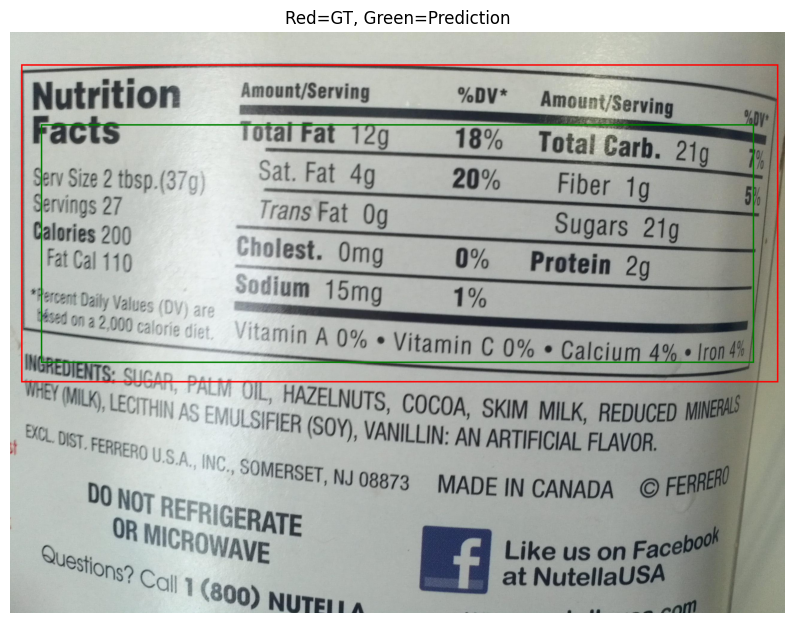

In [ ]:

# Draw prediction on top (green) - need to modify function to accept color
def draw_bbox_on_image(image, boxes_dict, color="red"):
    from PIL import Image, ImageDraw
    import requests
    from io import BytesIO

    img_draw = image.copy()
    draw = ImageDraw.Draw(img_draw)
    width, height = img_draw.size
    boxes = boxes_dict["boxes"].numpy() if hasattr(boxes_dict["boxes"], 'numpy') else boxes_dict["boxes"]
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        draw.rectangle([xmin * width, ymin * height, xmax * width, ymax * height], outline=color, width=5)
    return img_draw

def parse_bbox_output(output_text):
    # Handle Qwen's special format: <|bbox|>x1 y1 x2 y2</bbox>
    if '<|bbox|>' in output_text:
        # Extract content between tags
        bbox_str = output_text.split('<|bbox|>')[1].split('</bbox>')[0]
        # Split by spaces
        bbox = [float(x) for x in bbox_str.strip().split()]
    else:
        # Fallback for bracket format
        import ast
        bbox = ast.literal_eval(output_text)
    return bbox


pred_dict = {
    "boxes": torch.tensor([parse_bbox_output(pred_output)]),
    "category": ["nutrition_table"]
}

# Draw ground truth first (red)
img_with_gt = draw_bbox_on_image(image, ground_truth[image_id])


# Now call both
img_with_gt = draw_bbox_on_image(image, ground_truth[image_id], "red")
final_img = draw_bbox_on_image(img_with_gt, pred_dict, "green")

plt.figure(figsize=(10, 10))
plt.imshow(final_img)
plt.axis("off")
plt.title("Red=GT, Green=Prediction")
plt.show()

In [ ]:
prediction_data_set = {}
for i in range(10):  # Start with 10 for testing
    sample = nutrition_data["train"][i]
    image_id = sample["image_id"]
    image_url = sample["meta"]["image_url"]
    prediction_data_set[image_id] = predict_bbox(image_url, model, processor)
    print(f"Processed {image_id}")

print(f"Total predictions: {len(prediction_data_set)}")

Processed 0009800892204_1
Processed 0024842112219_3
Processed 3560070581849_11
Processed 0061954000539_4
Processed 25231656_1
Processed 0071300000021_4
Processed 3271820003053_3
Processed 20327132_2
Processed 0018894306016_1
Processed 0038900013400_2
Total predictions: 10


In [ ]:
prediction_data_set

{'0009800892204_1': '<|bbox|>0.04 0.16 0.96 0.57</bbox>',
 '0024842112219_3': '<|bbox|>0.23, 0.23, 0.77, 0.83|>',
 '3560070581849_11': '<|bbox|>0,0,1000,1000<|bbox|>',
 '0061954000539_4': '<|bbox|>110, 180, 889, 999</bbox>',
 '25231656_1': '[0.25, 0.26, 0.4, 0.46]',
 '0071300000021_4': '<|bbox|>0.0,0.0,0.99,0.99<|bbox|>',
 '3271820003053_3': '<|bbox|>0.31 0.36 0.64 0.61<|bbox|>',
 '20327132_2': 'Nutrition Information(112,207),(487,757)',
 '0018894306016_1': '<|bbox|>0.04 0.31 0.99 0.81|>',
 '0038900013400_2': '<|bbox|>196, 100, 674, 777|>'}

In [ ]:
import json

# Save as JSON (since it's just image_id -> string mapping)
with open('predictions.json', 'w') as f:
    json.dump(prediction_data_set, f)

print(f"Saved {len(prediction_data_set)} predictions to predictions.json")

# To load later:
# with open('predictions.json', 'r') as f:
#     prediction_data_set = json.load(f)

Saved 10 predictions to predictions.json


In [ ]:
# ok my mega check function
from scipy.optimize import linear_sum_assignment
from torchvision import ops
def evaluate(dict_predict,dict_ground_truth):
    all_ious = list()

    total_missed_real_boxes = 0
    total_extra_predicted = 0


    common_ids = set(dict_predict.keys()) & set(dict_ground_truth.keys())

    for image_id in common_ids:
        prediction_boxes = dict_predict[image_id]["boxes"]
        ground_truth_boxes = dict_ground_truth[image_id]["boxes"]

        total_predicted_boxes = len(prediction_boxes)
        total_ground_truth_boxes = len(ground_truth_boxes)

        # Calculate IoU matrix
        iou_matrix = ops.box_iou(prediction_boxes,ground_truth_boxes)
        # Hungarian matching
        pred_idx, gt_idx = linear_sum_assignment(-iou_matrix.numpy())

        # Get matched IoUs
        matched_ious = iou_matrix[pred_idx, gt_idx]
        all_ious.extend(matched_ious.tolist())

        # i have a bit doubt about this lines may be abs
        #
        total_missed_real_boxes += total_ground_truth_boxes - len(pred_idx)
        total_extra_predicted += total_predicted_boxes - len(matched_ious)

    return {
        'mean_iou': sum(all_ious) / len(all_ious),
        'missed_gt': total_missed_real_boxes,
        'extra_pred': total_extra_predicted
    }


In [ ]:
def parse_bbox_output(output_text):
    import re

    # Clean common issues
    text = output_text.strip()

    # Case 1: <|bbox|>...any closing variant
    if '<|bbox|>' in text:
        # Extract content between <|bbox|> and any closing (</bbox>, <|bbox|>, |>)
        match = re.search(r'<\|bbox\|>(.*?)(?:</bbox>|<\|bbox\|>|\|>)', text)
        if match:
            bbox_str = match.group(1).strip()
            # Handle both space and comma separated
            bbox = [float(x.strip()) for x in re.split(r'[,\s]+', bbox_str)]

            # Check if pixel coordinates (any value > 1)
            if any(x > 1 for x in bbox):
                # Assume 1000x1000 image, normalize
                bbox = [x/1000 for x in bbox]
            return bbox

    # Case 2: Bracket format [x1, y1, x2, y2]
    elif text.startswith('[') and text.endswith(']'):
        import ast
        return ast.literal_eval(text)

    # Case 3: "Nutrition Information(x1,y1),(x2,y2)"
    elif 'Nutrition' in text:
        match = re.findall(r'\((\d+),(\d+)\)', text)
        if len(match) == 2:
            x1, y1 = map(float, match[0])
            x2, y2 = map(float, match[1])
            # Normalize (assuming ~1000 pixel dimension)
            return [x1/1000, y1/1000, x2/1000, y2/1000]

    # Fallback: try to extract any 4 numbers
    numbers = re.findall(r'[\d.]+', text)
    if len(numbers) >= 4:
        bbox = [float(n) for n in numbers[:4]]
        if any(x > 1 for x in bbox):
            bbox = [x/1000 for x in bbox]
        return bbox

    raise ValueError(f"Could not parse: {text}")

# Test it
test_outputs = {
    'good': '<|bbox|>0.04 0.16 0.96 0.57</bbox>',
    'comma_wrong_close': '<|bbox|>0.23, 0.23, 0.77, 0.83|>',
    'pixels': '<|bbox|>110, 180, 889, 999</bbox>',
    'bracket': '[0.25, 0.26, 0.4, 0.46]',
    'nutrition': 'Nutrition Information(112,207),(487,757)'
}

for name, output in test_outputs.items():
    print(f"{name}: {parse_bbox_output(output)}")

good: [0.04, 0.16, 0.96, 0.57]
comma_wrong_close: [0.23, 0.23, 0.77, 0.83]
pixels: [0.11, 0.18, 0.889, 0.999]
bracket: [0.25, 0.26, 0.4, 0.46]
nutrition: [0.112, 0.207, 0.487, 0.757]


In [ ]:
# Reparse all predictions with the robust parser
predictions_parsed = {}
failed = []

for image_id, pred_string in prediction_data_set.items():
    try:
        bbox = parse_bbox_output(pred_string)
        predictions_parsed[image_id] = {
            "boxes": torch.tensor([bbox], dtype=torch.float32),
            "category": ["nutrition_table"]
        }
    except Exception as e:
        failed.append((image_id, pred_string))
        print(f"Failed {image_id}: {pred_string}")

print(f"Successfully parsed: {len(predictions_parsed)}/{len(prediction_data_set)}")
if failed:
    print(f"Failed: {len(failed)}")

# Re-run evaluation with properly parsed predictions
results = evaluate(predictions_parsed, ground_truth)
print(results)

Successfully parsed: 10/10
{'mean_iou': 0.5595704719424248, 'missed_gt': 0, 'extra_pred': 0}


Text(0.5, 1.0, '0009800892...\nIoU: 0.71')

(np.float64(-0.5), np.float64(2591.5), np.float64(1943.5), np.float64(-0.5))

Text(0.5, 1.0, '0024842112...\nIoU: 0.27')

(np.float64(-0.5), np.float64(305.5), np.float64(407.5), np.float64(-0.5))

Text(0.5, 1.0, '3560070581...\nIoU: 0.95')

(np.float64(-0.5), np.float64(691.5), np.float64(719.5), np.float64(-0.5))

Text(0.5, 1.0, '0061954000...\nIoU: 0.21')

(np.float64(-0.5), np.float64(3119.5), np.float64(4207.5), np.float64(-0.5))

Text(0.5, 1.0, '25231656_1...\nIoU: 0.46')

(np.float64(-0.5), np.float64(1943.5), np.float64(2591.5), np.float64(-0.5))

Text(0.5, 1.0, '0071300000...\nIoU: 0.84')

(np.float64(-0.5), np.float64(1999.5), np.float64(2665.5), np.float64(-0.5))

Text(0.5, 1.0, '3271820003...\nIoU: 0.06')

(np.float64(-0.5), np.float64(1999.5), np.float64(3554.5), np.float64(-0.5))

Text(0.5, 1.0, '20327132_2...\nIoU: 0.80')

(np.float64(-0.5), np.float64(2447.5), np.float64(3263.5), np.float64(-0.5))

Text(0.5, 1.0, '0018894306...\nIoU: 0.57')

(np.float64(-0.5), np.float64(1999.5), np.float64(1499.5), np.float64(-0.5))

Text(0.5, 1.0, '0038900013...\nIoU: 0.73')

(np.float64(-0.5), np.float64(1999.5), np.float64(1124.5), np.float64(-0.5))

Text(0.5, 0.98, 'All 10 Predictions - Red=GT, Green=Prediction')

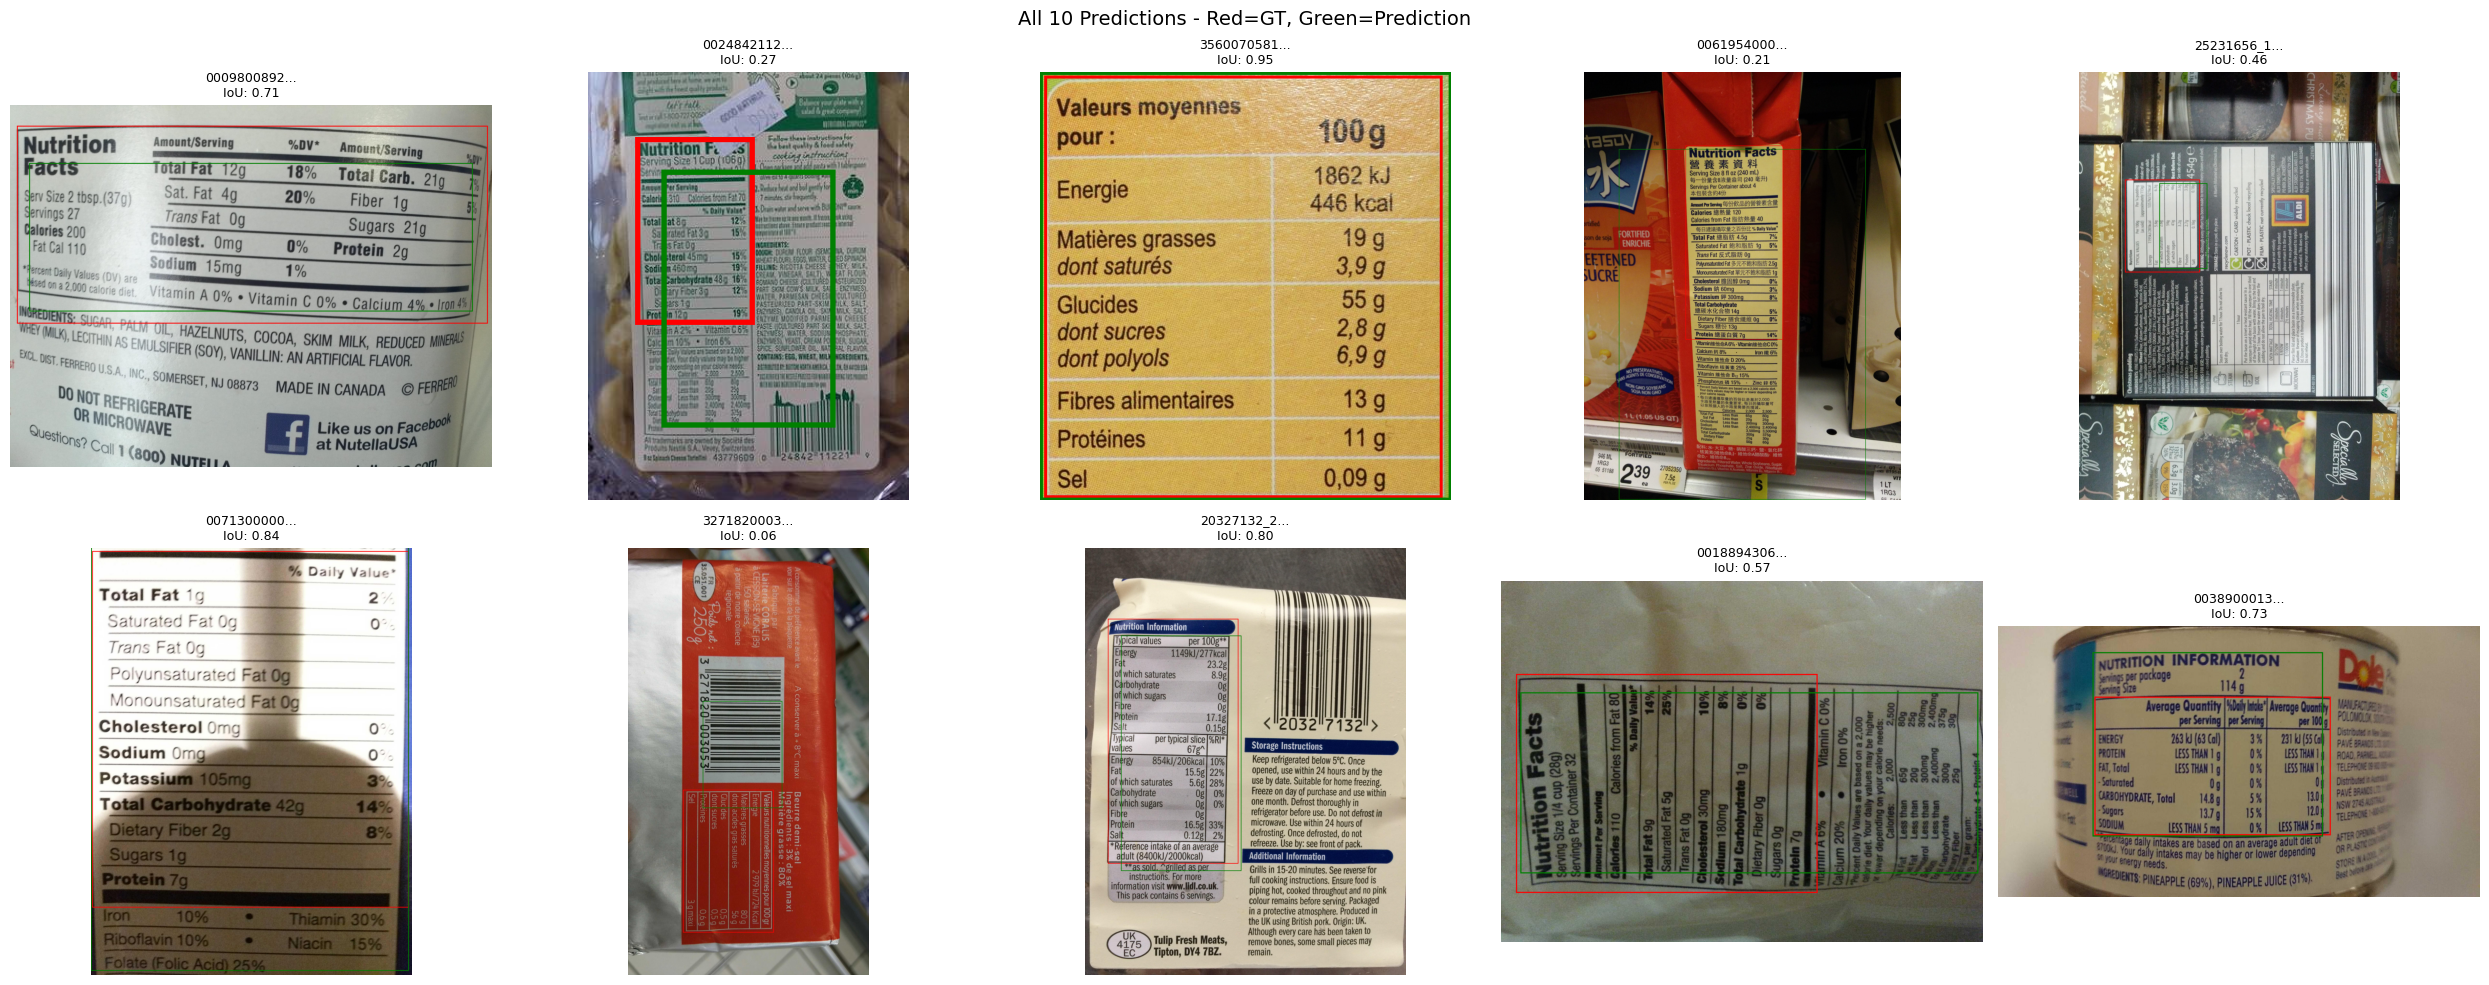

In [ ]:
import json
import matplotlib.pyplot as plt
from torchvision import ops

# Load predictions from file
with open('predictions.json', 'r') as f:
    prediction_data_set = json.load(f)

# Get all 10 image IDs
image_ids = list(prediction_data_set.keys())[:10]

fig, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.flatten()

for idx, image_id in enumerate(image_ids):
    # Find sample
    for sample in nutrition_data["train"]:
        if sample["image_id"] == image_id:
            break

    # Parse prediction with robust parser
    pred_dict = {
        "boxes": torch.tensor([parse_bbox_output(prediction_data_set[image_id])], dtype=torch.float32),
        "category": ["nutrition_table"]
    }

    # Draw using your function
    img_with_gt = draw_bbox_on_image(sample["image"], ground_truth[image_id], "red")
    final_img = draw_bbox_on_image(img_with_gt, pred_dict, "green")

    # Calculate IoU
    iou = ops.box_iou(pred_dict['boxes'], ground_truth[image_id]['boxes']).max().item()

    axes[idx].imshow(final_img)
    axes[idx].set_title(f"{image_id[:10]}...\nIoU: {iou:.2f}", fontsize=9)
    axes[idx].axis('off')

plt.suptitle("All 10 Predictions - Red=GT, Green=Prediction", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# ok very interesting it's not that bad as expected
# like images I though not good actually is solid :)
